<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Библиотеки" data-toc-modified-id="Библиотеки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Библиотеки</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#toxic-BERT" data-toc-modified-id="toxic-BERT-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>toxic-BERT</a></span></li><li><span><a href="#Токенизация" data-toc-modified-id="Токенизация-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Токенизация</a></span></li><li><span><a href="#Cuda" data-toc-modified-id="Cuda-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Cuda</a></span></li><li><span><a href="#Эмбеддинги" data-toc-modified-id="Эмбеддинги-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Эмбеддинги</a></span></li><li><span><a href="#Split" data-toc-modified-id="Split-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Split</a></span></li><li><span><a href="#(Up&amp;)Downsampling" data-toc-modified-id="(Up&amp;)Downsampling-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>(Up&amp;)Downsampling</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

~~(DistilBERT)~~

(toxic BERT)

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Алгоритм**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Библиотеки

In [1]:
# !pip install transformers

In [2]:
# !pip install torch

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from tqdm import notebook
import torch
import transformers as ppb
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
import gc
import multiprocessing

In [6]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
torch.__version__

'1.12.1'

## Подготовка

### Загрузка данных

In [8]:
fname = 'toxic_comments.csv'
pth1 = '/datasets/'
pth2 = ''

if os.path.exists(pth1+fname):
    df = pd.read_csv(pth1+fname)
elif os.path.exists(pth2+fname):
    df = pd.read_csv(pth2+fname)
else:
    print('Something is wrong')

In [9]:
df.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


In [10]:
df.shape

(159571, 2)

In [11]:
df.text.apply(len).describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text, dtype: float64

In [12]:
df['length'] = df.text.apply(len)

In [13]:
df.query('length > 4900')

,text,toxic,length
1184,"And \n\nPaganism\n\nSouthgate, who has a degre...",0,4908
2420,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT ...,1,4999
3954,"""\n\n(Ivo Banac)...A bit of nonteleological hi...",0,4946
4174,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,5000
4712,do go fuck off bastard\nDo Yyou Have a life?\n...,1,4969
...,...,...,...
156032,AIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AI...,1,5000
156437,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGO...,1,5000
157861,"""\n\n Made in the USA? http://rexcurry.net/wik...",0,4912
158572,"Originally born in OHIO,and raised on a yuppie...",0,4976


Похоже, что с очень длинными текстами нет проблемы (но среди них как раз много токсичных).

In [14]:
df.duplicated().sum()

0

Дубликатов нет.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
 2   length  159571 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


In [16]:
target = df.toxic
target.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    0
8    0
9    0
Name: toxic, dtype: int64

### toxic-BERT

In [17]:
multiprocessing.cpu_count()

8

In [18]:
torch.set_num_threads(multiprocessing.cpu_count())

In [19]:
# # For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# ## For BERT instead of distilBERT:
# #model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# # Load pretrained model/tokenizer
# tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# model = model_class.from_pretrained(pretrained_weights)

In [20]:
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

In [21]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'21.08.2022 21:38:08'

### Токенизация

In [22]:
%%time
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))

Wall time: 2min 21s


In [23]:
%%time
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Wall time: 20 s


In [24]:
max_len

512

In [25]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'21.08.2022 21:40:50'

In [26]:
np.array(padded).shape

(159571, 512)

In [27]:
attention_mask = np.where(padded != 0, 1, 0)

### Cuda

In [28]:
torch.cuda.is_available()

True

In [29]:
torch.cuda.device_count()

1

In [30]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=16)

In [31]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [32]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [33]:
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

### Эмбеддинги

In [ ]:
# embeddings = []
# embeddings = torch.zeros(1,768, device=device)
embeddings = torch.zeros(1,6, device=device)

In [36]:
batch_size = 50
model.eval()
model.to(device)
for i in notebook.tqdm(range(
#     1
    int(np.ceil(padded.shape[0] / batch_size))
)):
        batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():            
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
#         embeddings = torch.cat((embeddings, batch_embeddings[0][:,0,:]), 0)   # :,0,: - только CLS токен
#         print(batch_embeddings.logits.shape)
        embeddings = torch.cat((embeddings, batch_embeddings.logits), 0)
        
        del batch
        del attention_mask_batch
        del batch_embeddings

  0%|          | 0/3192 [00:00<?, ?it/s]

In [37]:
embeddings.shape

torch.Size([159572, 6])

In [38]:
embeddings[:2,:]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-7.1086, -9.1583, -8.6032, -9.1510, -8.6369, -8.9100]],
       device='cuda:0')

In [39]:
embeddings = embeddings[1:,:]
embeddings[:2,:]

tensor([[-7.1086, -9.1583, -8.6032, -9.1510, -8.6369, -8.9100],
        [-7.3556, -9.0493, -8.6204, -9.0126, -8.6399, -8.9054]],
       device='cuda:0')

In [40]:
embeddings.shape

torch.Size([159571, 6])

In [41]:
features = embeddings.cpu().numpy()
features.shape

(159571, 6)

In [42]:
features[:2]

array([[-7.10855  , -9.158272 , -8.6032095, -9.150958 , -8.636943 ,
        -8.910042 ],
       [-7.355632 , -9.049333 , -8.620355 , -9.012584 , -8.639869 ,
        -8.905448 ]], dtype=float32)

### Split

In [43]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.85, random_state=1734, 
    stratify=target,
    shuffle=True
)

In [44]:
target_train.mean()

0.10169208272404429

In [45]:
target_test.mean()

0.10167654604972132

In [46]:
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

In [47]:
target_train.head(15)

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     0
8     0
9     0
10    0
11    0
12    0
13    1
14    0
Name: toxic, dtype: int64

In [48]:
target_test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: toxic, dtype: int64

### (Up&)Downsampling

In [50]:
type(features_train)

numpy.ndarray

In [51]:
features_train = pd.DataFrame(features_train)

In [52]:
type(target_train)

pandas.core.series.Series

In [53]:
def upsample(features, target, repeat):
    features_zeros = features[target_train == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [54]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345678)
    
    return features_downsampled, target_downsampled

In [55]:
# features_train, target_train = upsample(features_train, target_train, 2)
features_train, target_train = downsample(features_train, target_train, 0.75)

print(target_train.mean())

0.13114224137931035


## Обучение

### Логистическая регрессия

In [56]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:41:23'

In [57]:
%%time
log_reg_model = LogisticRegression(random_state=245982, max_iter=300, class_weight='balanced', verbose=2,
                                  tol=0.00005)

params = dict(C=np.linspace(0.47, 0.64, 9), 
              penalty=['l2'],   #,'l1'
              solver=['lbfgs', 'liblinear' ],   # 'newton-cg', 'saga', 'sag'
              fit_intercept=[True]
             )
grid = GridSearchCV(log_reg_model, params, verbose=2, scoring='f1', cv=4, n_jobs=-1)
grid.fit(features_train, target_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[LibLinear]Wall time: 2.31 s


GridSearchCV(cv=4,
             estimator=LogisticRegression(class_weight='balanced', max_iter=300,
                                          random_state=245982, tol=5e-05,
                                          verbose=2),
             n_jobs=-1,
             param_grid={'C': array([0.47   , 0.49125, 0.5125 , 0.53375, 0.555  , 0.57625, 0.5975 ,
       0.61875, 0.64   ]),
                         'fit_intercept': [True], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=2)

In [58]:
best_lr = grid.best_estimator_

In [59]:
print(grid.best_params_,'\n')
print(grid.best_score_,'\n')

{'C': 0.5549999999999999, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'} 

0.92946749627566 



In [60]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:41:25'

### CatBoost

In [61]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:43:56'

In [62]:
%%time
cat_model = CatBoostClassifier(iterations=100, loss_function="CrossEntropy", eval_metric='F1', verbose=0, thread_count=8)
params = {'learning_rate': np.linspace(0.38, 0.5, num=30), 
          'depth': [5,6,7], 
          'l2_leaf_reg': [2,3,4], 
          'random_strength': [1, 1.2, 2]
         }
cat_model.randomized_search(params, X=features_train, y=target_train,
                            partition_random_seed=12479, verbose=10, plot=True, shuffle=True, stratified=True, 
                            cv=4, n_iter=48
                           );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9467455621
bestIteration = 4

0:	loss: 0.9467456	best: 0.9467456 (0)	total: 678ms	remaining: 31.8s

bestTest = 0.9485148515
bestIteration = 3


bestTest = 0.9475766568
bestIteration = 2


bestTest = 0.9470529471
bestIteration = 28


bestTest = 0.9465346535
bestIteration = 6


bestTest = 0.9475766568
bestIteration = 7


bestTest = 0.9464285714
bestIteration = 11


bestTest = 0.9464285714
bestIteration = 11


bestTest = 0.9465346535
bestIteration = 7


bestTest = 0.9475766568
bestIteration = 4


bestTest = 0.9462151394
bestIteration = 21

10:	loss: 0.9462151	best: 0.9485149 (1)	total: 4.92s	remaining: 16.6s

bestTest = 0.9438423645
bestIteration = 6


bestTest = 0.9452736318
bestIteration = 32


bestTest = 0.9474727453
bestIteration = 9


bestTest = 0.9474727453
bestIteration = 9


bestTest = 0.9473684211
bestIteration = 12


bestTest = 0.9453823237
bestIteration = 11


bestTest = 0.9454905847
bestIteration = 13


bestTest = 0.9433962264
bestIteration = 0


bestTest = 0.946

{'params': {'random_strength': 2,
  'depth': 6,
  'l2_leaf_reg': 4,
  'learning_rate': 0.4131034482758621},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Скриншот последнего результата ↓
</div>

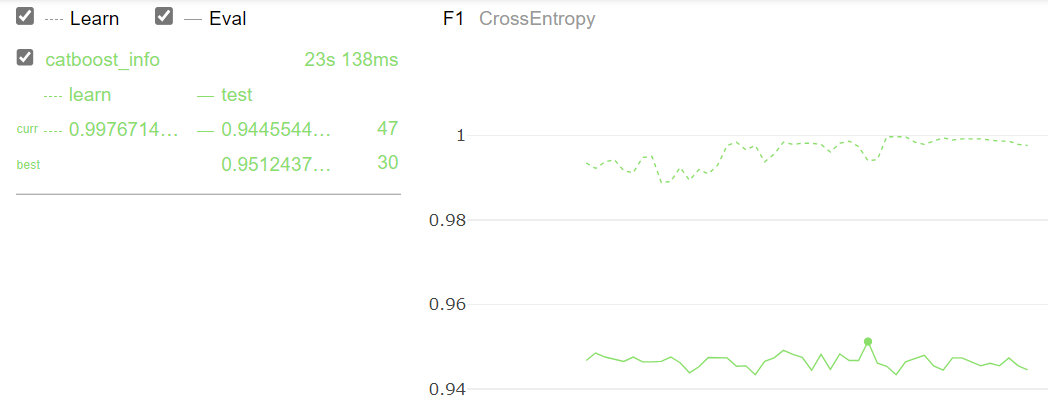

In [63]:
print(cat_model.get_best_score())
cat_model.get_params()

{'learn': {'F1': 0.9671322925225966, 'CrossEntropy': 0.023521115064239637}}


{'iterations': 100,
 'loss_function': 'CrossEntropy',
 'thread_count': 8,
 'verbose': 0,
 'eval_metric': 'F1',
 'random_strength': 2,
 'depth': 6,
 'l2_leaf_reg': 4,
 'learning_rate': 0.4131034482758621}

In [64]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'22.08.2022 00:44:22'

In [65]:
%%time
# cat_model.fit(X=features_train, y=target_train)
# predicted_cat = cat_model.predict(features_train)
# print(f"\nf1 on train: {f1_score(target_train, predicted_cat):3.2f}\n")
scores = cross_val_score(cat_model, features_train, target_train, cv=7, scoring='f1')
print("Catboost cross val score: %0.4f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Catboost cross val score: 0.9478 (+/- 0.01601)
Wall time: 2.25 s


In [66]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M:%S")

'22.08.2022 00:44:24'

### SVC

In [67]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:48:00'

In [68]:
%%time
svc_model = SVC(shrinking=True, probability=False, tol=0.0005, cache_size=300, class_weight='balanced', 
                verbose=True, max_iter=300, break_ties=False, random_state=16841)

params = dict(C=np.linspace(0.54, 0.58, 15),
              kernel=['linear', 'poly'], #, 'rbf', 'sigmoid'
              degree=[2,3,4], 
              gamma=['scale','auto'], 
              coef0=np.linspace(0.22, 0.34, 15), 
              decision_function_shape=['ovo', 'ovr']
             )
grid = RandomizedSearchCV(svc_model, params, verbose=3, scoring='f1', cv=4, n_jobs=8, n_iter=40)
grid.fit(features_train, target_train)
best_svc = grid.best_estimator_

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[LibSVM]Wall time: 6.12 s


C:\Users\skysh\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [69]:
print(grid.best_params_,'\n')
print(grid.best_score_,'\n')

{'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'decision_function_shape': 'ovr', 'coef0': 0.28, 'C': 0.5457142857142857} 

0.8883011517286199 



In [70]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:48:06'

### SGDClassifier

In [75]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:49:46'

In [76]:
%%time
sgd_model = SGDClassifier(fit_intercept=True, max_iter=700, tol=0.00001, shuffle=True, verbose=2, 
                          random_state=48253, class_weight='balanced', warm_start=False)

params = dict(loss=['modified_huber', 'perceptron'],   #  'hinge', 'squared_hinge', 
              penalty=['l2'],    #, 'elasticnet'
              alpha=[0.000001, 0.00001], 
              early_stopping=[True], 
              n_iter_no_change=[4,5,6,7,10,20], 
              learning_rate=['invscaling', 'adaptive'],   #'optimal', 'constant', 
              eta0=[5, 9, 13, 50], 
              power_t=[0.5, 0.9, 1.1], 
              validation_fraction=[0.08, 0.1, 0.1125], 
              average=[False, 5, 9]
             )
grid = RandomizedSearchCV(sgd_model, params, verbose=1, scoring='f1', cv=5, n_jobs=8, n_iter=96)
grid.fit(features_train, target_train)
best_sgd = grid.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
-- Epoch 1
Norm: 619.14, NNZs: 6, Bias: 80.492439, T: 16472, Avg. loss: 80.769869
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 506.70, NNZs: 6, Bias: 76.876361, T: 32944, Avg. loss: 47.193810
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 430.59, NNZs: 6, Bias: 70.312084, T: 49416, Avg. loss: 37.274806
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 372.49, NNZs: 6, Bias: 64.778749, T: 65888, Avg. loss: 28.482310
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 324.93, NNZs: 6, Bias: 61.309252, T: 82360, Avg. loss: 22.528128
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 284.96, NNZs: 6, Bias: 58.736899, T: 98832, Avg. loss: 19.308343
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 250.62, NNZs: 6, Bias: 56.455439, T: 115304, Avg. loss: 15.181316
Total training time: 0.02 seconds.
Convergence after 7 epochs took 0.02 seconds
Wall time: 16.1 s


In [77]:
print(grid.best_params_,'\n')
print(grid.best_score_,'\n')

{'validation_fraction': 0.1125, 'power_t': 0.5, 'penalty': 'l2', 'n_iter_no_change': 6, 'loss': 'modified_huber', 'learning_rate': 'invscaling', 'eta0': 13, 'early_stopping': True, 'average': False, 'alpha': 1e-06} 

0.9392897524749533 



In [78]:
dt.datetime.today().strftime('%d.%m.%Y %H:%M:%S')

'22.08.2022 00:50:02'

### Тестирование

Лучший показатель метрики получили для CatBoost, поэтому проверим эту модель на тестовой выборке.

In [81]:
%%time
# predicted_test_lr = best_lr.predict(features_test)
# print(f"Linear reg's final test F1: {f1_score(target_test, predicted_test_lr):3.3f}\n")

predicted_test_cat = cat_model.predict(features_test)
print(f"CatBoost's final test F1: {f1_score(target_test, predicted_test_cat):3.3f}\n")

# predicted_test_svc = best_svc.predict(features_test)
# print(f"SVC's final test F1: {f1_score(target_test, predicted_test_svc):3.3f}\n")

# predicted_test_sgd = best_sgd.predict(features_test)
# print(f"SGDClassifier's final test F1: {f1_score(target_test, predicted_test_sgd):3.3f}\n")

CatBoost's final test F1: 0.940

Wall time: 129 ms


### Проверка на адекватность

In [82]:
dummy = DummyClassifier(strategy='constant', #'stratified'
                        constant=1
                       )
scores = cross_val_score(dummy, features_test, target_test, scoring='f1')
print("Dummy classifier score: %0.4f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.1846 (+/- 0.00004)


Проверка на адекватность пройдена: результат dummy-классификатора значительно хуже.

## Выводы

Применяя вместо DistilBERT уже обученную модель toxic-BERT, удалось повысить показатель метрики *F1* с 0.68 до **0.94**. Лучшей моделью снова оказалась CatBoost. Но линейная регрессия и SGD не сильно отстают, к тому же линейная регрессия обучается быстрее.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны